In [ ]:
!pip install d2l==1.0.3

# Detección de Objetos y Bounding Boxes

En clases anteriores, introdujimos varios modelos para la clasificación de imágenes. En las tareas de clasificación de imágenes, asumimos que hay solo un *único* objeto principal en la imagen y solo nos enfocamos en cómo reconocer su categoría. Sin embargo, a menudo hay *múltiples* objetos en la imagen de interés. No solo queremos conocer sus categorías, sino también sus posiciones específicas en la imagen. En visión por computadora, nos referimos a estas tareas como *detección de objetos* (o *reconocimiento de objetos*).

La detección de objetos se ha aplicado ampliamente en muchos campos. Por ejemplo, la conducción autónoma necesita planificar rutas de viaje detectando las posiciones de vehículos, peatones, carreteras y obstáculos en las imágenes de video capturadas. Además, los robots pueden utilizar esta técnica para detectar y localizar objetos de interés a lo largo de su navegación en un entorno. Además, los sistemas de seguridad pueden necesitar detectar objetos anormales, como intrusos o bombas.

En esta clase, presentaremos varios métodos de aprendizaje profundo para la detección de objetos. Comenzaremos con una introducción a las *posiciones* (o *ubicaciones*) de los objetos.

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)

Cargaremos la imagen de muestra que se utilizará en esta sección. Podemos ver que hay un perro en el lado izquierdo de la imagen y un gato en el lado derecho.


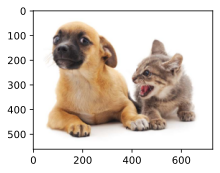

In [44]:
import requests
from PIL import Image
from io import BytesIO
response = requests.get("https://i.postimg.cc/76bP9RCP/catdog.jpg")
img = Image.open(BytesIO(response.content))
d2l.plt.imshow(img);

## Bounding Boxes

En la detección de objetos, generalmente usamos un *bounding box* para describir la ubicación espacial de un objeto. El bounding box es rectangular y se determina por las coordenadas $x$ e $y$ de la esquina superior izquierda del rectángulo y las coordenadas correspondientes de la esquina inferior derecha. Otra representación comúnmente usada del bounding box es la coordenada del centro $(x, y)$ del bounding box, junto con el ancho y la altura de la caja.

Aquí definimos funciones para convertir entre estas dos representaciones: `box_corner_to_center` convierte de la representación de dos esquinas a la presentación centro-ancho-altura, y `box_center_to_corner` viceversa. El argumento de entrada `boxes` debe ser un tensor bidimensional de forma ($n$, 4), donde $n$ es el número de bounding boxes.

In [35]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

Definiremos los bounding boxes del perro y del gato en la imagen basándonos en la información de las coordenadas. El origen de las coordenadas en la imagen es la esquina superior izquierda de la imagen, y hacia la derecha y hacia abajo son las direcciones positivas de los ejes $x$ e $y$, respectivamente.

In [36]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

Podemos verificar la corrección de las dos funciones de conversión de bounding boxes convirtiendo dos veces.

In [37]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

Vamos a dibujar los bounding boxes en la imagen para comprobar si son precisos.
Antes de dibujar, definiremos una función auxiliar `bbox_to_rect`. Representa el bounding box en el formato de bounding box del paquete `matplotlib`.

In [38]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

Después de agregar los bounding boxes en la imagen, podemos ver que el contorno principal de los dos objetos está básicamente dentro de los dos cuadros.

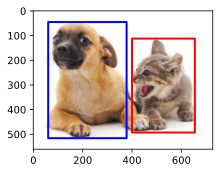

In [43]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## El Conjunto de Datos para la Detección de Objetos

No existe un conjunto de datos pequeño como MNIST y Fashion-MNIST en el campo de la detección de objetos. Para demostrar rápidamente los modelos de detección de objetos, **hemos recopilado y etiquetado un pequeño conjunto de datos**. Primero, tomamos fotos de bananas gratuitas de nuestra oficina y generamos 1000 imágenes de bananas con diferentes rotaciones y tamaños. Luego colocamos cada imagen de banana en una posición aleatoria sobre alguna imagen de fondo. Finalmente, etiquetamos las cajas delimitadoras para esas bananas en las imágenes.

## **Descargando el Conjunto de Datos**

El conjunto de datos de detección de bananas con todas las imágenes y archivos de etiquetas csv se puede descargar directamente de Internet.

In [40]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

### Leyendo el dataset

Vamos a leer el conjunto de datos de detección de bananas en la función `read_data_bananas` a continuación. El conjunto de datos incluye un archivo csv para etiquetas de clases de objetos y coordenadas de las cajas delimitadoras ground-truth en las esquinas superior izquierda e inferior derecha.

In [41]:
def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

Usando la función `read_data_bananas` para leer imágenes y etiquetas, la siguiente clase `BananasDataset` nos permitirá crear una instancia personalizada de `Dataset` para cargar el conjunto de datos de detección de bananas.

In [ ]:
class BananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

Finalmente, definimos la función `load_data_bananas` para retornar dos instancias de iteradores de datos, una para el conjunto de entrenamiento y otra para el conjunto de prueba. Para el conjunto de prueba, no es necesario leerlo en un orden aleatorio.

In [ ]:
def load_data_bananas(batch_size):
    """Load the banana detection dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

Vamos a leer un minibatch e imprimir las formas tanto de las imágenes como de las etiquetas en este minibatch. La forma del minibatch de imágenes, (tamaño del lote, número de canales, altura, ancho), parece familiar: es la misma que en nuestras tareas anteriores de clasificación de imágenes. La forma del minibatch de etiquetas es (tamaño del lote, $m$, 5), donde $m$ es el número máximo posible de bounding boxes que cualquier imagen tiene en el conjunto de datos.

Aunque la computación en minibatches es más eficiente, requiere que todos los ejemplos de imagen contengan el mismo número de bounding boxes para formar un minibatch mediante concatenación. En general, las imágenes pueden tener un número variable de bounding boxes; por lo tanto, las imágenes con menos de $m$ bounding boxes se rellenarán con bounding boxes falsas hasta alcanzar $m$. Luego, la etiqueta de cada bounding box está representada por un array de longitud 5. El primer elemento en el array es la clase del objeto en la bounding box, donde -1 indica una bounding box falsa para el relleno. Los cuatro elementos restantes del array son los valores de las coordenadas ($x$, $y$) de la esquina superior izquierda y la esquina inferior derecha de la bounding box (el rango está entre 0 y 1). Para el conjunto de datos de bananas, dado que solo hay una bounding box en cada imagen, tenemos $m=1$.

In [ ]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

Demostremos diez imágenes con sus bounding boxes de ground truth etiquetados. Podemos ver que las rotaciones, tamaños y posiciones de los plátanos varían en todas estas imágenes. Por supuesto, este es solo un conjunto de datos artificial simple. En la práctica, los conjuntos de datos del mundo real suelen ser mucho más complicados.

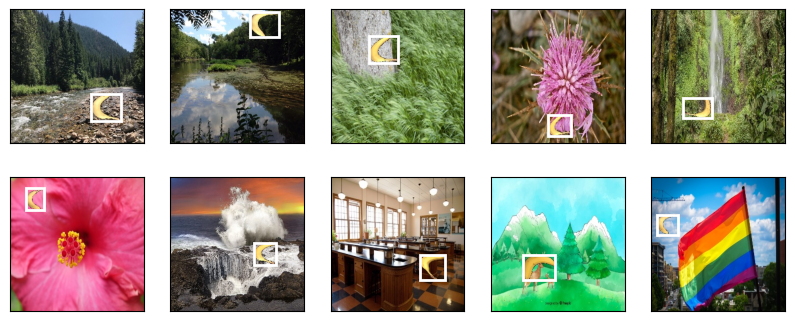

In [ ]:
imgs = (batch[0][:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])